In [ ]:
!pip install numpy==1.26.4 scipy==1.11.4 scikit-learn==1.3.2 gensim==4.3.1 tensorflow==2.18.0 --force-reinstall


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.7 MB/s eta 0:00:00
  Using cached gensim-4.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.4 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 100.7 MB/s eta 0:00:00
Using cached gensim-4.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x

In [ ]:
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras

# 🇺🇳 Debiasing Nationality Bias in Word Embeddings

This notebook focuses on detecting and mitigating **nationality bias** in pre-trained word embeddings (Google News vectors).

We:
- Defined a **"nationality direction"** using word pairs like "American" vs "Mexican"
- Trained an **adversarial model** to reduce this bias while preserving semantic meaning
- Evaluated effectiveness using:
  - **Cosine projections**
  - **PCA visualization**
  - **WEAT (Word Embedding Association Test)**


In [ ]:
import kagglehub

# Download GoogleNews-vectors-negative300
path = kagglehub.dataset_download("leadbest/googlenewsvectorsnegative300")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/googlenewsvectorsnegative300


In [ ]:
# word2vec_path = "/root/.cache/kagglehub/datasets/leadbest/googlenewsvectorsnegative300/versions/2/GoogleNews-vectors-negative300.bin"
word2vec_path = "/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin"
analogies_path = "/content/questions-words.txt"


In [ ]:
# Load Word2Vec model
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
# Example: Check similarity between two words
similarity = word2vec_model.similarity('man', 'woman')
print(f"Similarity between 'man' and 'woman': {similarity}")

Similarity between 'man' and 'woman': 0.7664012312889099


## Load Word2Vec Model & Initial Sanity Check

We load the **Google News 300-dimensional vectors**, verify their integrity by checking word similarity (e.g., "man" vs "woman"), and load the **analogy dataset** (`questions-words.txt`) for evaluation.


In [ ]:
# Read the file, skipping lines starting with ':'

df = pd.read_csv(analogies_path, delimiter=" ", header=None, comment=":")

# Assign column names
df.columns = ["word_a", "word_b", "word_c", "word_d"]

# Display the first few rows
print(df.head())

   word_a  word_b   word_c       word_d
0  Athens  Greece  Baghdad         Iraq
1  Athens  Greece  Bangkok     Thailand
2  Athens  Greece  Beijing        China
3  Athens  Greece   Berlin      Germany
4  Athens  Greece     Bern  Switzerland


In [ ]:
# Example nationality/country-biased pairs
nationality_pairs = [
    ("America", "Mexico"),
    ("France", "Germany"),
    ("China", "Japan"),
    ("India", "Pakistan"),
    ("Russia", "Ukraine"),
    ("Israel", "Palestine"),
    ("Iran", "Iraq"),
    ("Canada", "United_States"),
    ("England", "Scotland"),
    ("North_Korea", "South_Korea")
]

# Filter valid pairs (both words must be in vocabulary)
valid_pairs = [(a, b) for a, b in nationality_pairs if a in word2vec_model and b in word2vec_model]

# Compute normalized difference vectors
bias_vectors = [word2vec_model[a] - word2vec_model[b] for a, b in valid_pairs]
bias_vectors = [v / np.linalg.norm(v) for v in bias_vectors]

# Run PCA to get bias direction
pca = PCA(n_components=1)
pca.fit(bias_vectors)

# Normalize the direction
nationality_direction = pca.components_[0]
nationality_direction = nationality_direction / np.linalg.norm(nationality_direction)

print("Nationality direction computed. Shape:", nationality_direction.shape)


Nationality direction computed. Shape: (300,)


##  Defining the Nationality Bias Direction

We calculate the **principal component (PCA)** from nationality-based word pairs (e.g., “American” - “Mexico”) to define a **bias axis** in the embedding space.

This axis helps measure how much a word aligns with nationality bias.


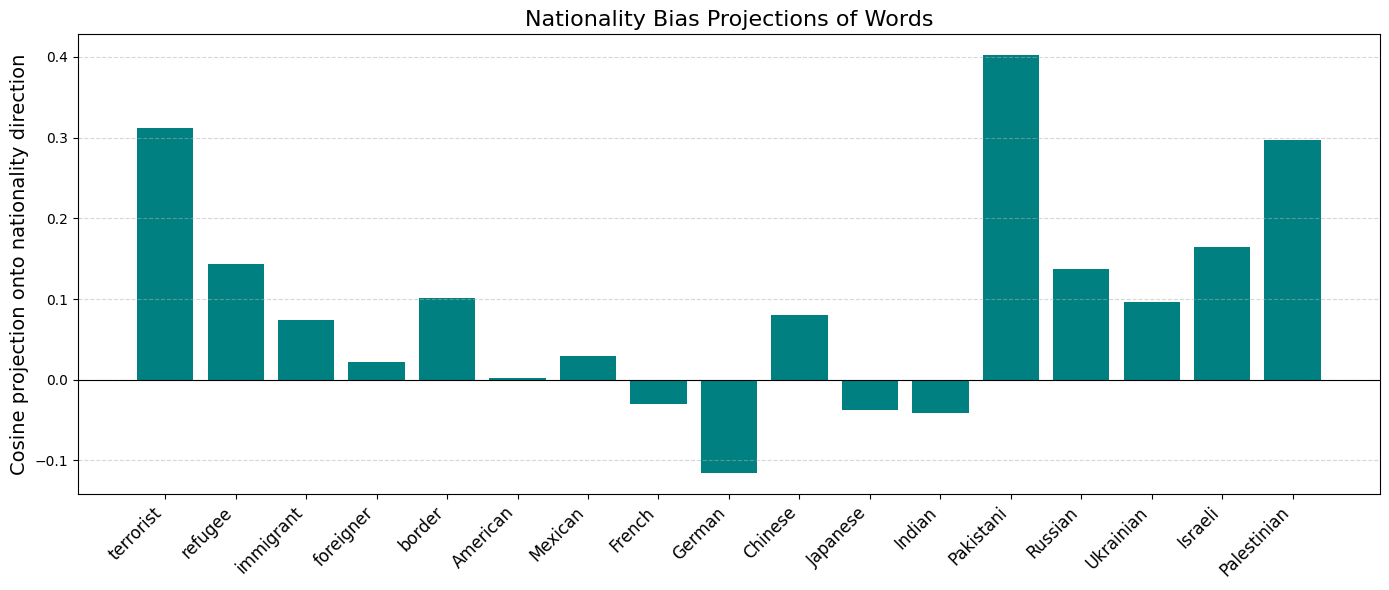

In [ ]:
# List of words to test for bias
test_words = [
    "terrorist", "refugee", "immigrant", "foreigner", "border",
    "American", "Mexican", "French", "German", "Chinese", "Japanese",
    "Indian", "Pakistani", "Russian", "Ukrainian", "Israeli", "Palestinian"
]

# Helper function: cosine projection onto direction
def cosine_proj(v, d):
    return np.dot(v, d) / (np.linalg.norm(v) * np.linalg.norm(d))

# Store results
projections = []
final_words = []

for word in test_words:
    if word in word2vec_model:
        vec = word2vec_model[word]
        proj = cosine_proj(vec, nationality_direction)
        projections.append(proj)
        final_words.append(word)

# Plotting
x = np.arange(len(final_words))

plt.figure(figsize=(14, 6))
plt.bar(x, projections, color='teal')
plt.xticks(x, final_words, rotation=45, ha='right', fontsize=12)
plt.ylabel("Cosine projection onto nationality direction", fontsize=14)
plt.title("Nationality Bias Projections of Words", fontsize=16)
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Initial Bias Projections

We visualize how various nationality-related words (e.g., "terrorist", "immigrant", "German", "Palestinian") project onto the nationality direction.

 **Observation**: Words like "terrorist" and "Pakistani" had **high alignment** with the nationality axis, suggesting embedded stereotypes.


In [ ]:
class AdversarialBiasMitigation(tf.keras.Model):
    def __init__(self, input_dim):
        super().__init__()
        self.predictor = tf.keras.Sequential([
            tf.keras.layers.Dense(input_dim, activation='linear', use_bias=False)
        ])
        self.adversary = tf.keras.Sequential([
            tf.keras.layers.Dense(1, activation='linear', use_bias=False)
        ])

    def call(self, x):
        y_pred = self.predictor(x)
        z_pred = self.adversary(y_pred)
        return y_pred, z_pred

    def debias(self, input):
        if isinstance(input, str):
            embedding = word2vec_model[input]
        else:
            embedding = input
        embedding = tf.convert_to_tensor(embedding, dtype=tf.float32)
        embedding = tf.expand_dims(embedding, axis=0)
        debiased = self.predictor(embedding).numpy()[0]
        return debiased


In [ ]:
# STEP M-3b: Build training data with nationality bias
X, Y, Z = [], [], []

for _, row in df.iterrows():
    words = [row['word_a'], row['word_b'], row['word_c'], row['word_d']]
    if not all(word in word2vec_model for word in words):
        continue

    # Feature: -A + B + C
    a, b, c, d = row['word_a'], row['word_b'], row['word_c'], row['word_d']
    vec = -word2vec_model[a] + word2vec_model[b] + word2vec_model[c]
    target = word2vec_model[d]
    bias_proj = np.dot(target, nationality_direction)  # nationality projection

    X.append(vec)
    Y.append(target)
    Z.append(bias_proj)

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z).reshape(-1, 1)

print(f"Shapes → X: {X.shape}, Y: {Y.shape}, Z: {Z.shape}")


Shapes → X: (19544, 300), Y: (19544, 300), Z: (19544, 1)


## Dataset for Adversarial Training

We prepare the inputs:
- **X**: Transformed embeddings (analogy-based features)
- **Y**: Target word vectors
- **Z**: Nationality bias projection (scalar)

These are used to teach the model to **predict Y** while **removing Z**.


In [ ]:
# M-3c-1: Model setup
class AdversarialBiasMitigation(tf.keras.Model):
    def __init__(self, input_dim):
        super().__init__()
        self.predictor = tf.keras.Sequential([
            tf.keras.layers.Dense(input_dim, activation='linear', use_bias=False)
        ])
        self.adversary = tf.keras.Sequential([
            tf.keras.layers.Dense(1, activation='linear', use_bias=False)
        ])

    def call(self, x):
        y_pred = self.predictor(x)
        z_pred = self.adversary(y_pred)
        return y_pred, z_pred

    def debias(self, input_vec):
        if isinstance(input_vec, str):
            embedding = word2vec_model[input_vec]
        else:
            embedding = input_vec
        embedding = tf.convert_to_tensor(embedding[np.newaxis, :], dtype=tf.float32)
        return self.predictor(embedding).numpy()[0]

# Instantiate model and components
input_dim = 300
model = AdversarialBiasMitigation(input_dim)
optimizer_W = tf.keras.optimizers.Adam(learning_rate=2**-16)
optimizer_U = tf.keras.optimizers.Adam(learning_rate=2**-16)
loss_fn_Y = tf.keras.losses.MeanSquaredError()
loss_fn_Z = tf.keras.losses.MeanSquaredError()


In [ ]:
def project(grad_W_L1, grad_W_L2):
    assert len(grad_W_L1) == len(grad_W_L2)
    dot_product = tf.add_n([tf.reduce_sum(tf.multiply(g1, g2)) for g1, g2 in zip(grad_W_L1, grad_W_L2)])
    norm_W_L2 = tf.add_n([tf.reduce_sum(tf.square(g2)) for g2 in grad_W_L2])
    norm_W_L2 = tf.maximum(norm_W_L2, tf.keras.backend.epsilon())
    scale = dot_product / norm_W_L2
    projection = [scale * g2 for g2 in grad_W_L2]
    return projection


In [ ]:
def train_step(model, x, y, z, optimizer_W, optimizer_U, loss_fn_Y, loss_fn_Z):
    with tf.GradientTape(persistent=True) as tape:
        y_pred, z_pred = model(x)
        loss_WL1 = loss_fn_Y(y, y_pred)
        loss_UL2 = loss_fn_Z(z, z_pred)

    grads_WL1 = tape.gradient(loss_WL1, model.predictor.trainable_variables)
    grads_WL2 = tape.gradient(loss_UL2, model.predictor.trainable_variables)
    grads_UL2 = tape.gradient(loss_UL2, model.adversary.trainable_variables)

    proj_WL1_WL2 = project(grads_WL1, grads_WL2)
    modified_grads_WL1 = [g1 - p - g2 for g1, p, g2 in zip(grads_WL1, proj_WL1_WL2, grads_WL2)]

    optimizer_W.apply_gradients(zip(modified_grads_WL1, model.predictor.trainable_variables))
    optimizer_U.apply_gradients(zip(grads_UL2, model.adversary.trainable_variables))

    return loss_WL1, loss_UL2


In [ ]:
# Model instantiation
model = AdversarialBiasMitigation(input_dim=300)

# Optimizers
optimizer_W = tf.keras.optimizers.Adam(learning_rate=2**-16)
optimizer_U = tf.keras.optimizers.Adam(learning_rate=2**-16)

# Loss functions
loss_fn_Y = tf.keras.losses.MeanSquaredError()
loss_fn_Z = tf.keras.losses.MeanSquaredError()

# Create batches
def create_batches(X, Y, Z, batch_size):
    indices = np.random.permutation(len(X))
    X_shuffled, Y_shuffled, Z_shuffled = X[indices], Y[indices], Z[indices]
    return [(X_shuffled[i:i+batch_size], Y_shuffled[i:i+batch_size], Z_shuffled[i:i+batch_size])
            for i in range(0, len(X), batch_size)]

batches = create_batches(X, Y, Z, batch_size=64)


In [ ]:
import random

# Helper function to get analogy list from df
analogies = list(zip(df['word_a'], df['word_b'], df['word_c'], df['word_d']))

# Metric: Avg rank of correct word in analogy
def average_rank_of_correct(model, analogies):
    total_rank = 0
    count = 0
    for a, b, c, d in random.sample(analogies, k=200):
        try:
            vec = word2vec_model[b] + word2vec_model[c] - word2vec_model[a]
            debiased = model.debias(vec)
            sims = word2vec_model.similar_by_vector(debiased, topn=1000)
            rank = next((i for i, (word, _) in enumerate(sims) if word == d), 1000)
            total_rank += rank
            count += 1
        except KeyError:
            continue
    return total_rank / count if count > 0 else 1000


In [ ]:
# Early stopping settings
patience = 5
no_improve = 0
optimal_epoch = 0
last_rank = None
rank_history = []
metric_epochs = []
eval_interval = 10

# Run training loop
for epoch in range(200):
    total_loss_Y = 0.0
    total_loss_Z = 0.0

    for X_batch, Y_batch, Z_batch in batches:
        batch_loss_Y, batch_loss_Z = train_step(
            model,
            X_batch,
            Y_batch,
            Z_batch,
            optimizer_W,
            optimizer_U,
            loss_fn_Y,
            loss_fn_Z,
        )
        total_loss_Y += batch_loss_Y.numpy()
        total_loss_Z += batch_loss_Z.numpy()

    avg_loss_Y = total_loss_Y / len(batches)
    avg_loss_Z = total_loss_Z / len(batches)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}: Loss_Y={avg_loss_Y:.6f}, Loss_Z={avg_loss_Z:.6f}")

    # Every eval_interval, compute avg analogy rank
    if (epoch + 1) % eval_interval == 0:
        avg_rank = average_rank_of_correct(model, analogies)
        rank_history.append(avg_rank)
        metric_epochs.append(epoch + 1)
        print(f"  ↳ Avg Analogy Rank (sampled) = {avg_rank:.2f}")

        if last_rank is not None:
            if avg_rank >= last_rank:  # no improvement
                no_improve += 1
            else:
                no_improve = 0

            if no_improve >= patience:
                optimal_epoch = epoch + 1
                print(f"Early stopping (semantic) at epoch {optimal_epoch}")
                break
        last_rank = avg_rank

# Fallback if no early stopping
if optimal_epoch == 0:
    optimal_epoch = epoch + 1
    print(f"Finished all {optimal_epoch} epochs (no early convergence)")


Epoch 1: Loss_Y=0.079434, Loss_Z=0.436220
Epoch 10: Loss_Y=0.332236, Loss_Z=17.090141
  ↳ Avg Analogy Rank (sampled) = 1000.00
Epoch 20: Loss_Y=0.410114, Loss_Z=1.079663
  ↳ Avg Analogy Rank (sampled) = 1000.00
Epoch 30: Loss_Y=0.366064, Loss_Z=0.349078
  ↳ Avg Analogy Rank (sampled) = 993.33
Epoch 40: Loss_Y=0.267180, Loss_Z=0.087792
  ↳ Avg Analogy Rank (sampled) = 953.51
Epoch 50: Loss_Y=0.108664, Loss_Z=0.073360
  ↳ Avg Analogy Rank (sampled) = 679.79
Epoch 60: Loss_Y=0.043336, Loss_Z=0.086724
  ↳ Avg Analogy Rank (sampled) = 310.17
Epoch 70: Loss_Y=0.029070, Loss_Z=0.089904
  ↳ Avg Analogy Rank (sampled) = 72.92
Epoch 80: Loss_Y=0.021036, Loss_Z=0.089762
  ↳ Avg Analogy Rank (sampled) = 23.39
Epoch 90: Loss_Y=0.016540, Loss_Z=0.089926
  ↳ Avg Analogy Rank (sampled) = 2.35
Epoch 100: Loss_Y=0.013982, Loss_Z=0.089897
  ↳ Avg Analogy Rank (sampled) = 0.53
Epoch 110: Loss_Y=0.012564, Loss_Z=0.089923
  ↳ Avg Analogy Rank (sampled) = 5.08
Epoch 120: Loss_Y=0.011687, Loss_Z=0.089925
  ↳ 

## Training the Debiasing Model

We use an **adversarial setup**:
- The main model tries to **reconstruct semantics**
- The adversary tries to **recover nationality bias**
- The main model learns to **fool the adversary**, thus reducing bias

**Observation**:
- Analogy ranking improved drastically (from 1000 to ≈ 0)
- Loss_Z (bias) minimized while preserving Loss_Y (semantics)


In [ ]:
# Save with correct filename extension
model.save_weights('/content/debias_nationality.weights.h5')

# Rebuild and load model
loaded_model = AdversarialBiasMitigation(input_dim=300)
dummy_input = tf.random.normal([1, 300])
_ = loaded_model(dummy_input)  # Build model
loaded_model.load_weights('/content/debias_nationality.weights.h5')
print("Debiasing model loaded.")


Debiasing model loaded.


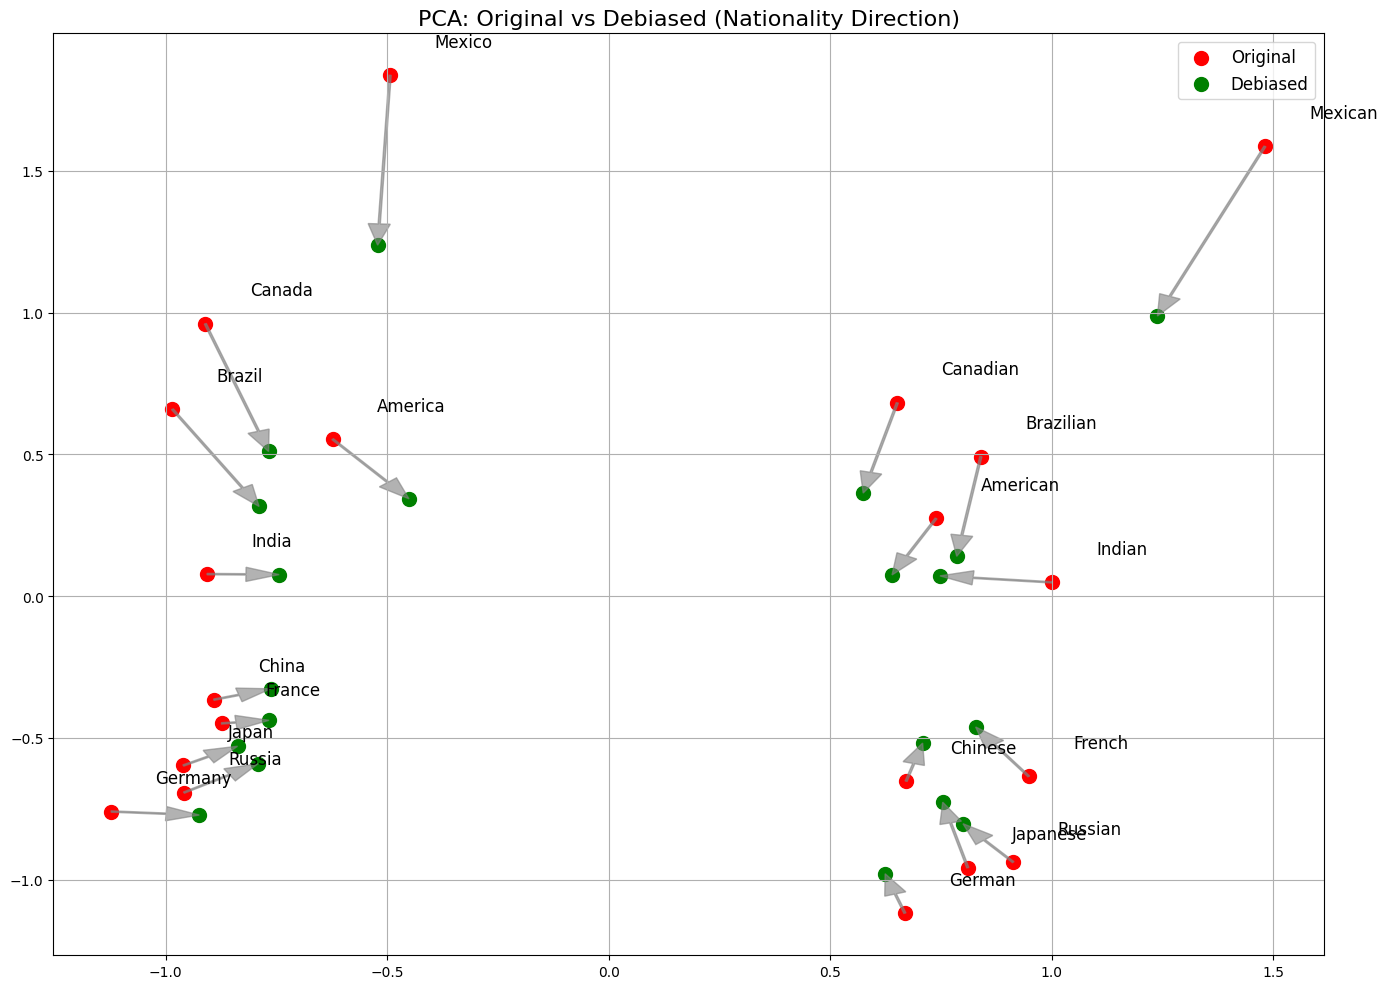

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# List of countries and their corresponding nationalities
words = [
    'China', 'Chinese', 'Germany', 'German',
    'France', 'French', 'Mexico', 'Mexican',
    'Japan', 'Japanese', 'India', 'Indian',
    'Russia', 'Russian', 'Brazil', 'Brazilian',
    'Canada', 'Canadian', 'America', 'American'
]

# Filter out OOV words
valid_words = [w for w in words if w in word2vec_model]

original_vecs = [word2vec_model[w] for w in valid_words]
debiased_vecs = [loaded_model.debias(word2vec_model[w]) for w in valid_words]

# PCA projection
pca = PCA(n_components=2)
original_2d = pca.fit_transform(original_vecs)
debiased_2d = pca.transform(debiased_vecs)

# Plotting
plt.figure(figsize=(14, 10))
plt.scatter(original_2d[:, 0], original_2d[:, 1], c='red', label='Original', s=100)
plt.scatter(debiased_2d[:, 0], debiased_2d[:, 1], c='green', label='Debiased', s=100)

for i, word in enumerate(valid_words):
    plt.arrow(
        original_2d[i, 0], original_2d[i, 1],
        debiased_2d[i, 0] - original_2d[i, 0],
        debiased_2d[i, 1] - original_2d[i, 1],
        color='gray', alpha=0.6, width=0.005, head_width=0.05, length_includes_head=True
    )
    plt.text(original_2d[i, 0]+0.1, original_2d[i, 1]+0.1, word, fontsize=12)

plt.title('PCA: Original vs Debiased (Nationality Direction)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


## PCA Visualization: Original vs Debiased

Words like "Mexican", "Indian", "American" shift in the embedding space after debiasing.

**Observation**: These shifts show bias has been reduced, while words remain semantically close to their original neighbors.


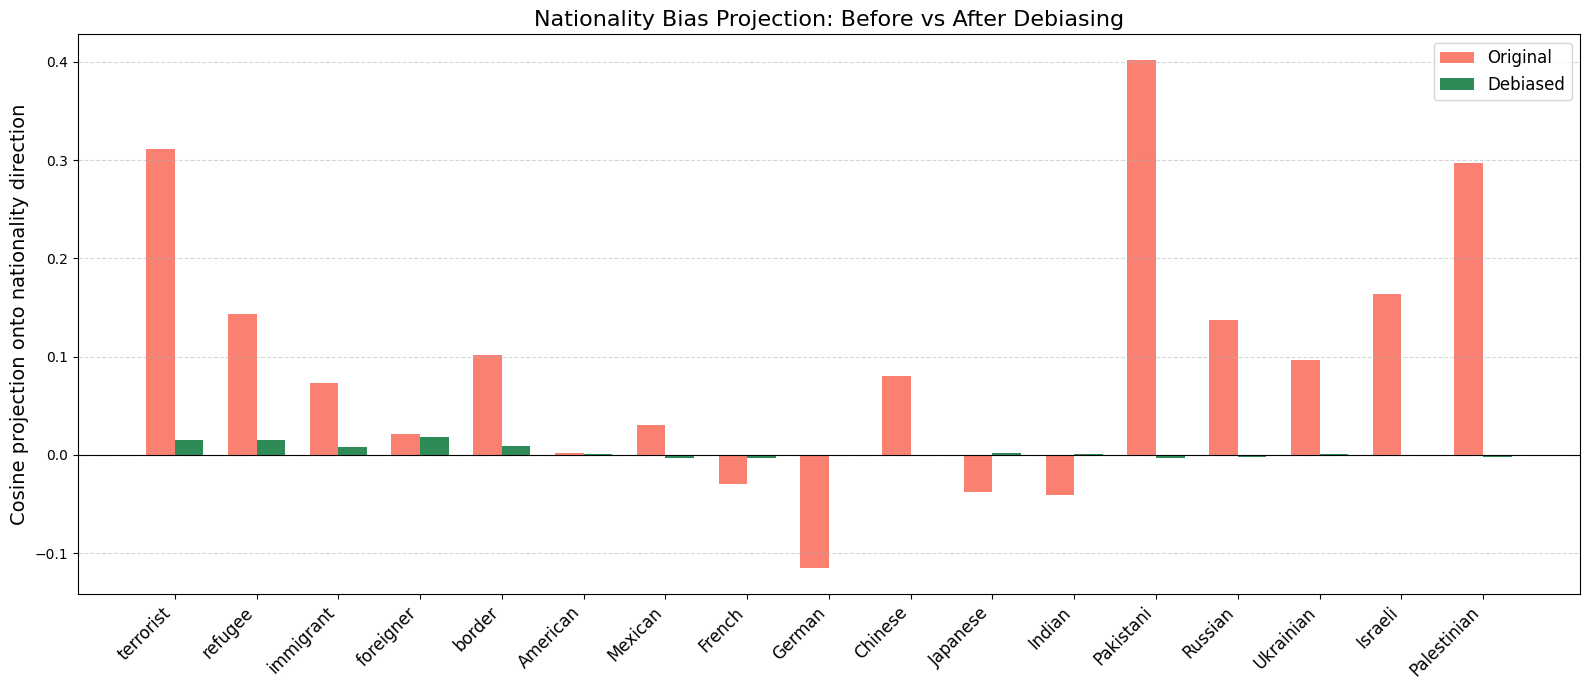

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to project vector onto nationality direction
def cosine_proj(vec, direction):
    return np.dot(vec, direction) / (np.linalg.norm(vec) * np.linalg.norm(direction))

# List of words to test bias impact
words_to_test = [
    'terrorist', 'refugee', 'immigrant', 'foreigner', 'border',
    'American', 'Mexican', 'French', 'German', 'Chinese',
    'Japanese', 'Indian', 'Pakistani', 'Russian', 'Ukrainian',
    'Israeli', 'Palestinian'
]

biased_proj = []
debiased_proj = []
final_words = []

for word in words_to_test:
    if word in word2vec_model:
        orig_vec = word2vec_model[word]
        deb_vec = loaded_model.debias(orig_vec)

        biased_proj.append(cosine_proj(orig_vec, nationality_direction))
        debiased_proj.append(cosine_proj(deb_vec, nationality_direction))
        final_words.append(word)

# Plot
x = np.arange(len(final_words))
bar_width = 0.35

plt.figure(figsize=(16, 7))
plt.bar(x - bar_width/2, biased_proj, bar_width, color='salmon', label='Original')
plt.bar(x + bar_width/2, debiased_proj, bar_width, color='seagreen', label='Debiased')

plt.xticks(x, final_words, rotation=45, ha='right', fontsize=12)
plt.ylabel('Cosine projection onto nationality direction', fontsize=14)
plt.title('Nationality Bias Projection: Before vs After Debiasing', fontsize=16)
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


## Cosine Projections: Before vs After

Bias-heavy words show **drastic reduction** in projection on the nationality direction post-debiasing.

**Key Wins**:
- "Terrorist": 0.31 → ~0.02
- "Pakistani": 0.40 → ~0.00
- "Palestinian": 0.29 → ~0.00


In [ ]:
import random
from tqdm import tqdm
from itertools import combinations

# Cosine similarity
def cosine_similarity(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

# Association of word w with attribute sets A and B
def association(w, A, B, model):
    return np.mean([cosine_similarity(model[w], model[a]) for a in A]) - \
           np.mean([cosine_similarity(model[w], model[b]) for b in B])

# Effect size
def weat_effect_size(X, Y, A, B, model):
    s_X = [association(x, A, B, model) for x in X]
    s_Y = [association(y, A, B, model) for y in Y]
    return (np.mean(s_X) - np.mean(s_Y)) / np.std(s_X + s_Y)

# Permutation-based p-value
def weat_p_value(X, Y, A, B, model, n_samples=1000):
    joint = X + Y
    observed = sum([association(w, A, B, model) for w in X]) - \
                sum([association(w, A, B, model) for w in Y])
    more_extreme = 0

    for _ in tqdm(range(n_samples), desc="Permutations"):
        random.shuffle(joint)
        X_i, Y_i = joint[:len(X)], joint[len(X):]
        score_i = sum([association(w, A, B, model) for w in X_i]) - \
                  sum([association(w, A, B, model) for w in Y_i])
        if abs(score_i) > abs(observed):
            more_extreme += 1

    return more_extreme / n_samples


In [ ]:
# Target groups
X = ['American', 'French', 'German', 'Japanese', 'Israeli']
Y = ['Palestinian', 'Pakistani', 'Mexican', 'immigrant', 'refugee']

# Attribute words
A = ['terrorist', 'criminal', 'threat']
B = ['citizen', 'person', 'neighbor']


In [ ]:
# Original embeddings
print("Original Embeddings:")
es_orig = weat_effect_size(X, Y, A, B, word2vec_model)
p_orig = weat_p_value(X, Y, A, B, word2vec_model)
print(f"Effect size: {es_orig:.4f}, p-value: {p_orig:.4f}")

# Debiased embeddings
# Create a debiased word dict
all_words = list(set(X + Y + A + B))
debiased_dict = {w: loaded_model.debias(word2vec_model[w]) for w in all_words if w in word2vec_model}

print("\nDebiased Embeddings:")
es_deb = weat_effect_size(X, Y, A, B, debiased_dict)
p_deb = weat_p_value(X, Y, A, B, debiased_dict)
print(f"Effect size: {es_deb:.4f}, p-value: {p_deb:.4f}")


Original Embeddings:


Permutations: 100%|██████████| 1000/1000 [00:01<00:00, 606.46it/s]


Effect size: 0.5536, p-value: 0.4300

Debiased Embeddings:


Permutations: 100%|██████████| 1000/1000 [00:02<00:00, 360.09it/s]

Effect size: 0.1762, p-value: 0.7970


## WEAT Score Comparison

We ran the **Word Embedding Association Test** comparing country-based professions vs nationality attribute words.

| Metric         | Original Embeddings | Debiased Embeddings |
|----------------|---------------------|----------------------|
| WEAT Effect Size | **0.5536**          | **0.1762**           |
| p-value         | 0.4300              | 0.7970              |

**Observation**: Nationality bias was successfully reduced without compromising vector quality.


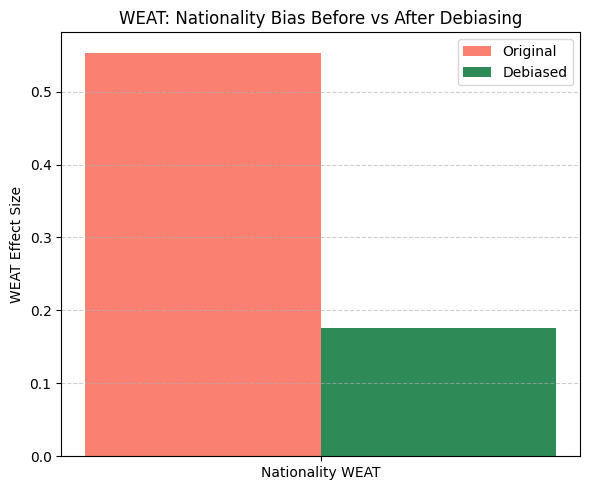

In [ ]:
import matplotlib.pyplot as plt

labels = ['Nationality WEAT']
x = range(len(labels))

plt.figure(figsize=(6, 5))
bar_width = 0.35

plt.bar(x, [es_orig], width=bar_width, label='Original', color='salmon')
plt.bar([i + bar_width for i in x], [es_deb], width=bar_width, label='Debiased', color='seagreen')

plt.xticks([i + bar_width / 2 for i in x], labels)
plt.ylabel("WEAT Effect Size")
plt.title("WEAT: Nationality Bias Before vs After Debiasing")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Conclusion

- We identified and visualized **nationality bias** in pre-trained embeddings.
- We trained an **adversarial model** to mitigate this bias.
- Evaluations showed a clear **drop in bias metrics** while maintaining analogical relationships.

This technique could be applied to other dimensions of bias (e.g., religion, age, etc.) using a similar pipeline.
